# 一、手撕损失函数

## 1. MAE Loss
MAE (Mean Absolute Error) 又称为L1 Loss，用于衡量预测值 $\hat{y}$ 与真实值 $y$ 之差的绝对值的均值。

$$L_{\text{MAE}} = \dfrac{1}{n}\displaystyle\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

- 使用场景：回归问题
- 优点：
  - 对异常值不敏感
- 缺点：
  - 在零点处不可导，优化相对困难
  - 对所有误差的惩罚都是一样的，不能特别关注大误差样本

In [38]:
import torch
import torch.nn as nn
class MyMAELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        return torch.mean(abs(y_pred - y_true))
    
y_true = torch.FloatTensor([1, 2, 3, 4, 5])
y_pred = torch.FloatTensor([1.1, 2.5, 3.5, 4.5, 5.5])

torch_mae = nn.L1Loss()
my_mae = MyMAELoss()

print(f"Pytorch MAE: {torch_mae(y_pred, y_true)}")
print(f"My MAE: {my_mae(y_pred, y_true)}")

Pytorch MAE: 0.41999998688697815
My MAE: 0.41999998688697815


## 2. MSE Loss
MSE（Mean Squared Error）机器学习中最常用的损失函数之一，又称为L2 Loss，用于衡量预测值 $\hat{y}$ 与真实值 $y$ 之差的平方和的均值。

$$L_{\text{MSE}} = \dfrac{1}{n}\displaystyle\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

In [39]:
import torch
import torch.nn as nn

class MyMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        return torch.mean((y_pred - y_true) ** 2)
    
y_true = torch.FloatTensor([1, 2, 3, 4, 5])
y_pred = torch.FloatTensor([1.1, 2.5, 3.5, 4.5, 5.5])

torch_mse = nn.MSELoss()
my_mse = MyMSELoss()

print(f"Pytorch MSE: {torch_mse(y_pred, y_true)}")
print(f"My MSE: {my_mse(y_pred, y_true)}")

Pytorch MSE: 0.2019999921321869
My MSE: 0.2019999921321869


## 3. CE Loss
CE (Cross Entropy) 用于衡量预测概率分布与真实概率分布之间的差异。

给定真实分布 $P$ 和预测分布 $Q$: $$H(P,Q) = -\sum_{i=1}^N P(x_i)\log Q(x_i)$$

在分类任务中，真实标签常采用 one-hot 编码，公式简化为：

$$L_{\text{CE}} = -\frac{1}{N}\sum_{i=1}^{N}\sum_{c=1}^{C} y_c \log(\hat{y}_c)$$

其中: $N$是样本数量，$C$ 为类别总数，$\hat{y}_c$ 是 Softmax后预测的概率；外层求和遍历每个样本，内层求和遍历每个类别，最后除以$N$计算平均损失

> one-hot编码的标签向量：只有真实类别位置的$y_c = 1$, 其他位置的$y_c = 0$

- 使用场景：分类问题
- 优点：
  - 能有效处理多分类问题
  - 对于错误预测有较大惩罚
- 缺点：
  - 对类别不平衡敏感：当训练数据中不同类别的样本数量差异很大时，模型会**倾向于预测样本数量多**的类别，因为这样可以让损失函数值更小。（Focal Loss可以处理类别不平衡的问题）
  - 可能对噪声标签敏感：当数据集中存在错误标注的样本时，CE Loss会强制模型去拟合这些错误标签，导致模型性能下降。

注：
1. PyTorch的`CrossEntropyLoss`已经集成了`log_softmax`和`NLL Loss`
2. PyTorch的实现接受的是**类别索引**，而不是one-hot编码
3. 实际应用中通常会添加一个很小的epsilon值来避免log(0)的情况

CrossEntropyLoss 等价于 LogSoftmax + NLLLoss，单个样本的CE loss推导如下：（$C$ 为类别总数）

1. Softmax: 将原始分数 logits（可以是任意实数） 映射成概率（在(0, 1)区间内），且所有输出值的和为1 $$\text{softmax}(x_i) = \frac{\exp(x_i)}{\sum_{j=1}^C \exp(x_j)}$$
2. LogSoftmax: $$\begin{aligned}\text{log\_softmax}(x_i) &= \log\left(\frac{\exp(x_i)}{\sum_{j=1}^C \exp(x_j)}\right)\\&= x_i - \log\left( \sum_{j=1}^C \exp(x_j)\right)\end{aligned}$$
3. NLLLoss(负对数似然损失)：对于预测概率 $p$ 和真实标签 $y$，假设真实类别为k，即只有$y_k = 1$ $$\begin{aligned}\text{NLLLoss}(y, p) &= -\sum_{i=1}^{C} y_i \log(p_i)\\&=-\log(p_k)\end{aligned}$$
4. CELoss: 对于输入 $x$ 和真实标签 $y$ $$\begin{aligned}\text{CrossEntropy}(y, x) &=-\sum_{i=1}^{C} y_i \log(\hat{y}_i)\\&= -\sum_{i=1}^C y_i \log(\text{softmax}(x_i))\\&=-\sum_{i=1}^C y_i\,\text{log\_softmax}(x_i)\\&=-\sum_{i=1}^C y_i\left(x_i - \log\left( \sum_{j=1}^C \exp(x_j)\right)\right)\end{aligned}$$

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyCELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_pred, y_true, print_info=False):
        log_softmax = F.log_softmax(y_pred, dim = 1)
        if print_info:
            print(f"softmax: \n{F.softmax(y_pred, dim = 1)}")
            print(f"log_softmax: \n{log_softmax}")
            print(f"y_true * log_softmax: \n{y_true * log_softmax}")
            print(f"torch.sum(y_true * log_softmax, dim=1):\n{torch.sum(y_true * log_softmax, dim=1)}")
        return -torch.mean(torch.sum(y_true * log_softmax, dim = 1))

# shape：[batch_size, num_classes]
# 假设有4个样本，每个样本是3分类问题
y_pred = torch.FloatTensor([[2.0, 1.0, 0.1], 
                           [0.1, 2.0, 1.0],
                           [0.1, 0.1, 2.0],
                           [0.2, 6.5, 3.0]])  # 预测的原始logits

# one-hot编码的真实标签
y_true = torch.FloatTensor([[1, 0, 0],
                           [0, 1, 0],
                           [0, 0, 1],
                           [0, 0, 1]])

torch_ce = nn.CrossEntropyLoss()
my_ce = MyCELoss()

# PyTorch的CrossEntropyLoss需要的是类别索引，而不是one-hot编码
y_true_indices = torch.argmax(y_true, dim=1)    # tensor([0, 1, 2, 2])

print(f"Pytorch CE: {torch_ce(y_pred, y_true_indices)}\n\n")
print(f"My CE: {my_ce(y_pred, y_true, print_info=True)}")

Pytorch CE: 1.156822919845581


softmax: 
tensor([[0.6590, 0.2424, 0.0986],
        [0.0986, 0.6590, 0.2424],
        [0.1151, 0.1151, 0.7697],
        [0.0018, 0.9690, 0.0293]])
log_softmax: 
tensor([[-0.4170, -1.4170, -2.3170],
        [-2.3170, -0.4170, -1.4170],
        [-2.1617, -2.1617, -0.2617],
        [-6.3315, -0.0315, -3.5315]])
y_true * log_softmax: 
tensor([[-0.4170, -0.0000, -0.0000],
        [-0.0000, -0.4170, -0.0000],
        [-0.0000, -0.0000, -0.2617],
        [-0.0000, -0.0000, -3.5315]])
torch.sum(y_true * log_softmax, dim=1):
tensor([-0.4170, -0.4170, -0.2617, -3.5315])
My CE: 1.156822919845581


未归一化的高斯核：$$f(x)=e^{\frac{−(x−\mu)^2}{2\sigma^2}}\in(0, 1]$$在 $x=\mu$ 处取到最大值 1，随着 $|x−\mu|\rightarrow\infty$ 单调趋近于 0

当$\sigma=2$
- $\begin{aligned}f(\mu - 1)&=e^{\frac{−((\mu - 1)−\mu)^2}{2\sigma^2}}\\&=e^{\frac{−1}{8}}\\&=0.8825\end{aligned}$
- $\begin{aligned}f(\mu - 2)&=e^{\frac{−((\mu - 2)−\mu)^2}{2\sigma^2}}\\&=e^{\frac{−4}{8}}\\&=0.6065\end{aligned}$
- $\begin{aligned}f(\mu - 3)&=e^{\frac{−((\mu - 3)−\mu)^2}{2\sigma^2}}\\&=e^{\frac{−9}{8}}\\&=0.3247\end{aligned}$
- $\begin{aligned}f(\mu - 4)&=e^{\frac{−((\mu - 4)−\mu)^2}{2\sigma^2}}\\&=e^{\frac{−16}{8}}\\&=0.1353\end{aligned}$
- $\begin{aligned}f(\mu - 5)&=e^{\frac{−((\mu - 5)−\mu)^2}{2\sigma^2}}\\&=e^{\frac{−25}{8}}\\&=0.0439\end{aligned}$

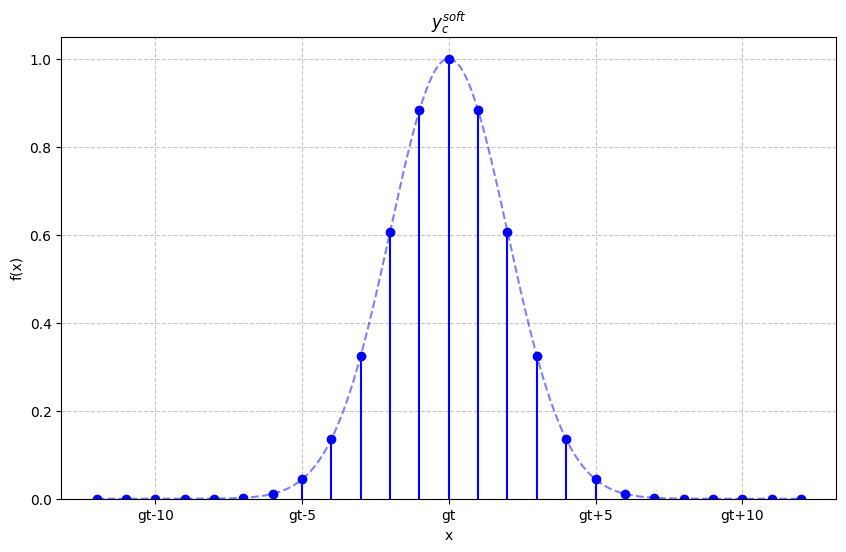

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_function(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

# 参数设置
mu = 0  
sigma = 2  

# 生成离散点和连续点
x_discrete = np.arange(mu-12, mu+13)  
y_discrete = gaussian_function(x_discrete, mu, sigma)

x_continuous = np.linspace(mu-12, mu+12, 1000)
y_continuous = gaussian_function(x_continuous, mu, sigma)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(x_continuous, y_continuous, 'b--', alpha=0.5, label='Continuous')
plt.stem(x_discrete, y_discrete, linefmt='b-', markerfmt='bo', basefmt=' ', label='Discrete')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'$y^{soft}_{c}$')
plt.ylim(bottom=0)

# 修改x轴标签，每5个点标注一次
x_ticks = np.arange(mu-10, mu+11, 5)  # 每5个点取一个刻度
x_labels = []
for x in x_ticks:
    if x == 0:
        x_labels.append('gt')
    elif x > 0:
        x_labels.append(f'gt+{abs(x)}')
    else:
        x_labels.append(f'gt-{abs(x)}')

plt.xticks(x_ticks, x_labels)

plt.show()


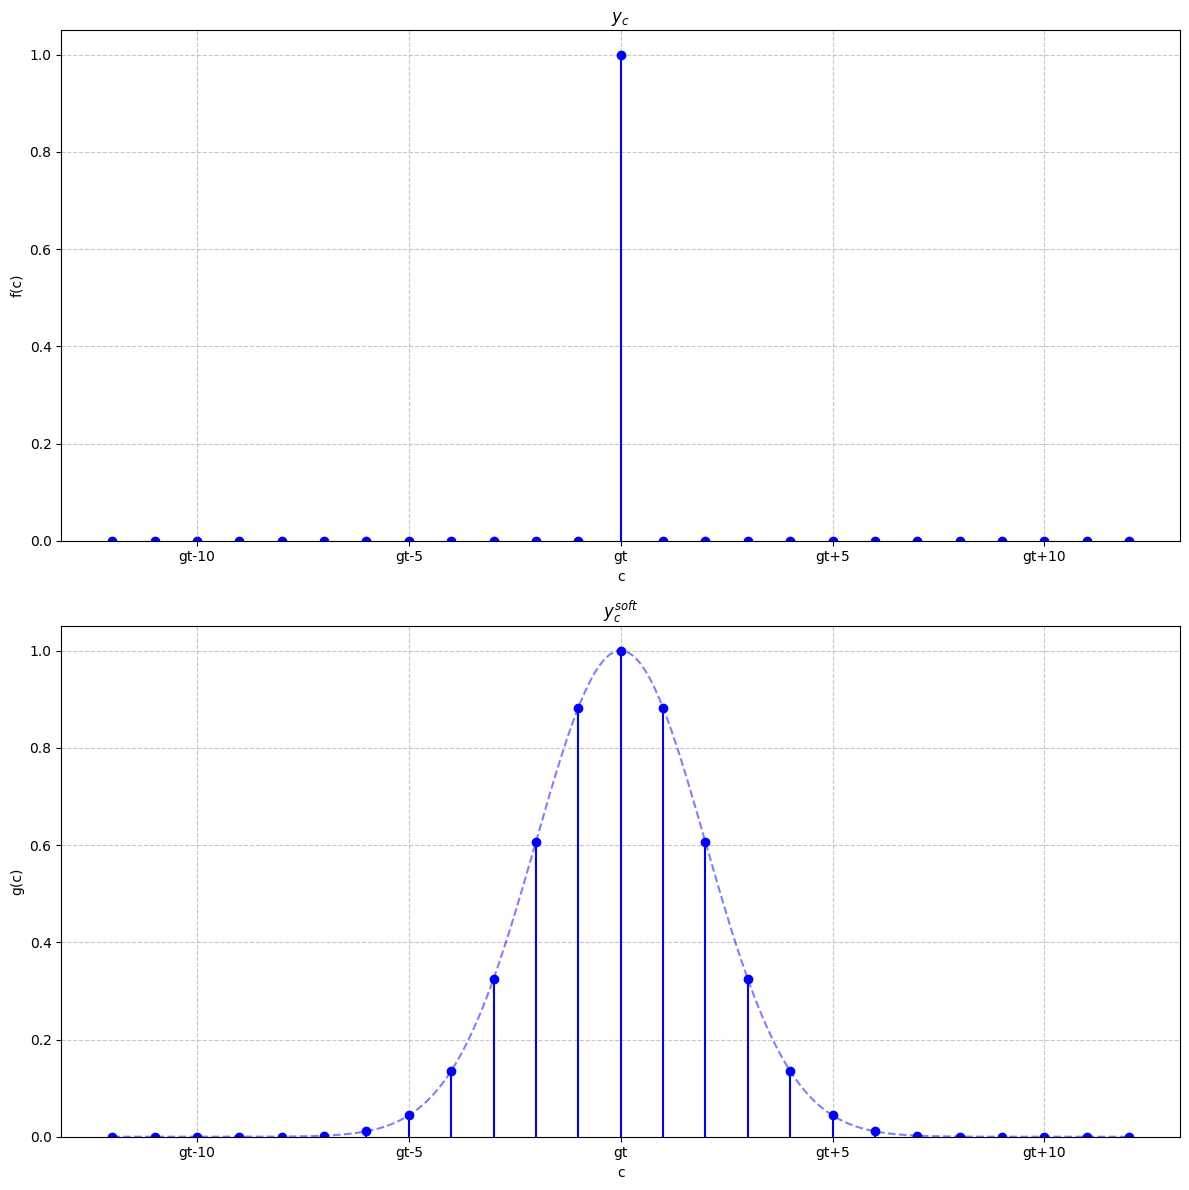

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 创建图形和子图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# 上图：冲激函数
x_discrete_impulse = np.arange(-12, 13)
y_discrete_impulse = np.zeros_like(x_discrete_impulse)
y_discrete_impulse[x_discrete_impulse == 0] = 1

ax1.stem(x_discrete_impulse, y_discrete_impulse, linefmt='b-', markerfmt='bo', basefmt=' ', label='Discrete')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xlabel('c')
ax1.set_ylabel('f(c)')
ax1.set_title(r'$y_{c}$')
ax1.set_ylim(bottom=0)

# 下图：高斯函数
def gaussian_function(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

mu, sigma = 0, 2
x_discrete = np.arange(mu-12, mu+13)
y_discrete = gaussian_function(x_discrete, mu, sigma)

x_continuous = np.linspace(mu-12, mu+12, 1000)
y_continuous = gaussian_function(x_continuous, mu, sigma)

ax2.plot(x_continuous, y_continuous, 'b--', alpha=0.5, label='Continuous')
ax2.stem(x_discrete, y_discrete, linefmt='b-', markerfmt='bo', basefmt=' ', label='Discrete')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xlabel('c')
ax2.set_ylabel('g(c)')
ax2.set_title(r'$y^{soft}_{c}$')
ax2.set_ylim(bottom=0)

# 为两个子图设置x轴标签
for ax in [ax1, ax2]:
    x_ticks = np.arange(-10, 11, 5)
    x_labels = []
    for x in x_ticks:
        if x == 0:
            x_labels.append('gt')
        elif x > 0:
            x_labels.append(f'gt+{abs(x)}')
        else:
            x_labels.append(f'gt-{abs(x)}')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)

plt.tight_layout()
plt.show()


标准CE:$$L_{\text{CE}} = -\frac{1}{N}\sum_{i=1}^{N}\sum_{c=1}^{C} y_c \log(\hat{y}_c)$$


$$y_c = f(c)= \begin{cases} 
1, & \text{gt} \\
0, & \text{otherwise}
\end{cases}$$

---

修改后的CE:$$L_{\text{CE}_\text{revised}} = -\frac{1}{N}\sum_{i=1}^{N}\sum_{c=1}^{C} y^{\text{soft}}_{c} \log(\hat{y}_c)$$

$$y_c^{\text{soft}}=g(c)=e^{\frac{−(c−\text{gt})^2}{2\sigma^2}}\in(0, 1]$$

$y_c^{\text{soft}}$在 $x=\text{gt}$ 处取到最大值 1，随着 $|x−\mu|\rightarrow\infty$ 单调趋近于 0

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(threshold=10**8)
class GaussianCrossEntropyLoss(nn.Module):
    def __init__(self, device, max_char_count, sigma_factor=2.0, clamp_min=0.35):
        super().__init__()
        self.device = device
        self.max_char_count = max_char_count
        self.sigma_factor = sigma_factor
        self.clamp_min = clamp_min
        
    def forward(self, y_pred, y_true, print_info=False):  # y_pred.shape: [b, max_char_count]    y_true.shape: [b]
        # mu
        centers = y_true.unsqueeze(-1)  # shape: [b, 1]
        
        # 位置索引
        positions = torch.arange(self.max_char_count, device=self.device).float()  # shape: [max_char_count]
        positions = positions.expand(y_true.shape[0], -1)  # shape: [b, max_char_count]
        
        # sigma
        # sigma_weight = (centers.permute(1, 0) / self.max_char_count)
        # sigma_weight = (centers.permute(1, 0) / (self.max_char_count / 2)).clamp(min=self.clamp_min) # shape: [b]
        # sigma = sigma_weight * self.sigma_factor * torch.ones_like(y_true, device=self.device).float() # shape: [b]
        sigma = self.sigma_factor * torch.ones_like(y_true, device=self.device).float()
        
        # 高斯分布
        diff = positions - centers  # (x-mu).shape: [b, max_char_count]
        y_true_soft = torch.exp(-(diff.pow(2) / (2 * sigma.pow(2).unsqueeze(-1))))  # shape: [b, max_char_count]
        
        loss = -(y_true_soft * F.log_softmax(y_pred, dim=-1)).sum(dim=-1).mean()
        
        if print_info:
            print(f"centers:\n{centers}\n")
            # print(f"sigma_weight_:\n{sigma_weight_}\n")
            # print(f"sigma_weight:\n{sigma_weight}\n")
            print(f"positions:\n{positions}\n")
            print(f"sigma:\n{sigma}\n")
            print(f"diff:\n{diff}")
            print(f"y_true_soft\n{y_true_soft}")
            print(f"y_true_soft.sum(dim=-1)\n{y_true_soft.sum(dim=-1)}")
        return loss
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_char_count = 512
gce = GaussianCrossEntropyLoss(device, max_char_count, sigma_factor=2, clamp_min=0.35)
# y_pred = torch.FloatTensor([[2.0, 1.0, 0.1, 8.0, 9.0, 2.0, 1.0, 0.1, 8.0, 9.0, 2.0, 1.0, 0.1, 8.0, 9.0, 11.0], 
#                            [12.0, 1.5, 9.1, 18.0, 9.0, 2.0, 1.0, 20.1, 3.0, 9.0, 14.0, 1.0, 6.1, 2.0, 9.0, 1.0],])  # 预测的原始logits
# y_true = torch.FloatTensor([7.0, 15.0])

y_pred = (torch.rand(2, max_char_count, dtype=torch.float32) - 0.5) * 5
y_true = torch.FloatTensor([3.0, 140.0])

print(gce(y_pred, y_true, True))


centers:
tensor([[  3.],
        [140.]])

positions:
tensor([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
          12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
          24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
          36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
          48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
          60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
          72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
          84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
          96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
         108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
         120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
         132., 133., 134., 135., 136., 137., 138., 139.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class GaussianCrossEntropyLoss(nn.Module):
    def __init__(self, device, num_classes, sigma_factor=2.0):
        super().__init__()
        self.device = device
        self.num_classes = num_classes
        self.sigma_factor = sigma_factor
        
    def forward(self, y_pred, y_true):  # y_pred.shape: [b, num_classes]    y_true.shape: [b]
        # gt
        centers = y_true.unsqueeze(-1)  # shape: [b, 1]
        
        # 位置索引
        positions = torch.arange(self.num_classes, device=self.device).float()  # shape: [num_classes]
        positions = positions.expand(y_true.shape[0], -1)  # shape: [b, num_classes]
        
        # sigma
        sigma = self.sigma_factor * torch.ones_like(y_true, device=self.device).float()
        
        # 高斯分布
        diff = positions - centers  # (c-gt).shape: [b, num_classes]
        y_true_soft = torch.exp(-(diff.pow(2) / (2 * sigma.pow(2).unsqueeze(-1))))  # shape: [b, num_classes]
        
        loss = -(y_true_soft * F.log_softmax(y_pred, dim=-1)).sum(dim=-1).mean()
        
        return loss
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_char_count = 512
gce = GaussianCrossEntropyLoss(device, max_char_count, sigma_factor=2)
# y_pred = torch.FloatTensor([[2.0, 1.0, 0.1, 8.0, 9.0, 2.0, 1.0, 0.1, 8.0, 9.0, 2.0, 1.0, 0.1, 8.0, 9.0, 11.0], 
#                            [12.0, 1.5, 9.1, 18.0, 9.0, 2.0, 1.0, 20.1, 3.0, 9.0, 14.0, 1.0, 6.1, 2.0, 9.0, 1.0],])  # 预测的原始logits
# y_true = torch.FloatTensor([7.0, 15.0])

y_pred = (torch.rand(2, max_char_count, dtype=torch.float32) - 0.5) * 5
y_true = torch.FloatTensor([3.0, 140.0])

print(gce(y_pred, y_true))


tensor(37.7917)


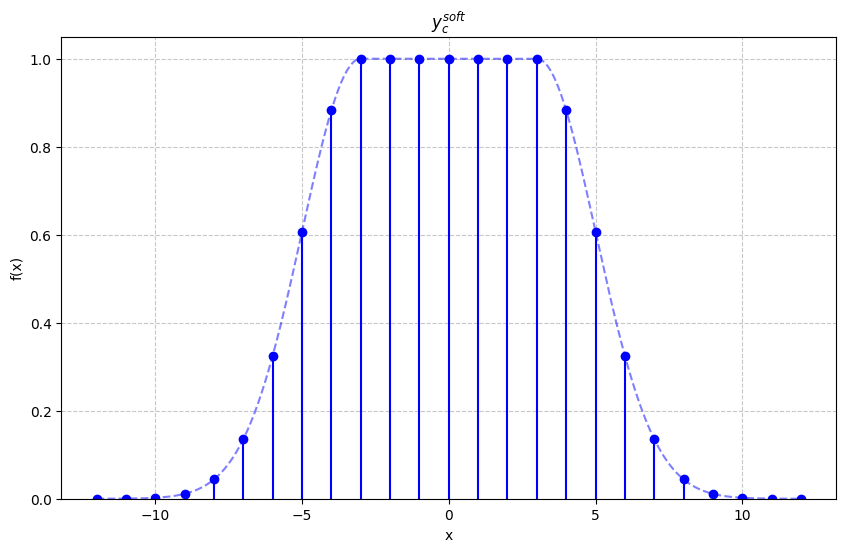

In [152]:
import numpy as np
import matplotlib.pyplot as plt

def piecewise_function(x, mu, sigma, tolerance_width):
    y = np.zeros_like(x, dtype=float)  
    
    left_center = mu - tolerance_width   
    right_center = mu + tolerance_width  
    
    mask1 = x <= mu-tolerance_width
    y[mask1] = np.exp(-(x[mask1] - left_center)**2/(2*sigma**2))
    
    mask2 = (x > mu-tolerance_width) & (x < mu+tolerance_width)
    y[mask2] = 1
    
    mask_left = x == mu-tolerance_width
    mask_right = x == mu+tolerance_width
    y[mask_left] = np.exp(-(mu-tolerance_width - left_center)**2/(2*sigma**2))
    y[mask_right] = np.exp(-(mu+tolerance_width - right_center)**2/(2*sigma**2))
    
    mask3 = x > mu+tolerance_width
    y[mask3] = np.exp(-(x[mask3] - right_center)**2/(2*sigma**2))
    
    return y

# 参数设置
mu = 0  
sigma = 2  
tolerance_width = 3

x_discrete = np.arange(mu-12, mu+13)  
y_discrete = piecewise_function(x_discrete, mu, sigma, tolerance_width)

x_continuous = np.linspace(mu-12, mu+12, 1000)
y_continuous = piecewise_function(x_continuous, mu, sigma, tolerance_width)

plt.figure(figsize=(10, 6))
plt.plot(x_continuous, y_continuous, 'b--', alpha=0.5, label='Continuous')
plt.stem(x_discrete, y_discrete, linefmt='b-', markerfmt='bo', basefmt=' ', label='Discrete')  # 修改这行

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'$y^{soft}_{c}$')

# plt.text(mu-tolerance_width-0.5, 0.5, f'x=μ-{tolerance_width}', rotation=90)
# plt.text(mu+tolerance_width-0.5, 0.5, f'x=μ+{tolerance_width}', rotation=90)

plt.ylim(bottom=0)

plt.show()


$\mu = \text{ground truth class}$

$M_{\text{char}} = 512$

$\sigma = 2\max(0.35, \frac{2\mu}{M_{\text{char}}})$

$y^{\text{soft}}_{c} = \begin{cases} 
e^{\frac{-(x-(\mu-3))^2}{2\sigma^2}} & x < \mu-3 \\
1 & \mu-3 \leq x \leq \mu+3 \\
e^{\frac{-(x-(\mu+3))^2}{2\sigma^2}} & x > \mu+3
\end{cases}$

$L_{\text{AGCE}} = -\frac{1}{N(2w+1)}\sum_{i=1}^{N}\sum_{c=1}^{C} y^{\text{soft}}_{c} \log(\hat{y}_c)\qquad\qquad (w=3)$

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(threshold=10**8)
class AdaptiveGaussianCrossEntropyLoss(nn.Module):
    def __init__(self, device, max_char_count, sigma_factor=2.0, clamp_min=0.35, tolerance_width=5):
        super().__init__()
        self.device = device
        self.max_char_count = max_char_count
        self.sigma_factor = sigma_factor
        self.clamp_min = clamp_min
        self.tolerance_width = tolerance_width
        
    def forward(self, y_pred, y_true, print_info=False):  # y_pred.shape: [b, max_char_count]    y_true.shape: [b]
        # mu
        centers = y_true.unsqueeze(-1)  # shape: [b, 1]
        # mu - tolerance_width
        left_centers = centers - self.tolerance_width
        # mu + tolerance_width
        right_centers = centers + self.tolerance_width
        
        # 位置索引
        positions = torch.arange(self.max_char_count, device=self.device).float()  # shape: [max_char_count]
        positions = positions.expand(y_true.shape[0], -1)  # shape: [b, max_char_count]
        
        # sigma
        sigma_weight = (centers.permute(1, 0) / (self.max_char_count / 2)).clamp(min=self.clamp_min) # shape: [b]
        sigma = sigma_weight * self.sigma_factor * torch.ones_like(y_true, device=self.device).float() # shape: [b]
        
        # 中间区域mask
        diff = positions - centers
        center_mask= (diff.abs() <= self.tolerance_width).float()
        # mu - tolerance_width左边的高斯分布 和 mask
        left_diff = positions - left_centers
        left_gaussian = torch.exp(-(left_diff.pow(2) / (2 * sigma.pow(2).unsqueeze(-1))))
        left_mask = (diff < -self.tolerance_width).float()
        # mu + tolerance_width右边的高斯分布 和 mask
        right_diff = positions - right_centers
        right_gaussian = torch.exp(-(right_diff.pow(2) / (2 * sigma.pow(2).unsqueeze(-1))))
        right_mask = (diff > self.tolerance_width).float()

        y_true_soft = (center_mask * 1.0 +          # 中间
                      left_mask * left_gaussian +   # 左边高斯
                      right_mask * right_gaussian)  # 右边高斯

        # diff = positions - centers  # (x-mu).shape: [b, max_char_count]
        # y_true_soft = torch.exp(-(diff.pow(2) / (2 * sigma.pow(2).unsqueeze(-1))))  # shape: [b, max_char_count]
        
        loss = -(y_true_soft * F.log_softmax(y_pred, dim=-1)).sum(dim=-1).mean() / (2 * self.tolerance_width + 1)
        # loss = -(y_true_soft * F.log_softmax(y_pred, dim=-1)).sum(dim=-1).mean()
        
        if print_info:
            print(f"centers:\n{centers}\n")
            # print(f"center_mask:\n{center_mask}\n")
            # print(f"left_mask:\n{left_mask}\n")
            # print(f"right_mask:\n{right_mask}\n")
            print(f"sigma_weight:\n{sigma_weight}\n")
            print(f"positions:\n{positions}\n")
            print(f"sigma:\n{sigma}\n")
            print(f"diff:\n{diff}")
            print(f"y_true_soft\n{y_true_soft}")
            print(f"y_true_soft.sum(dim=-1)\n{y_true_soft.sum(dim=-1)}")
        return loss
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_char_count = 512
ag_ce = AdaptiveGaussianCrossEntropyLoss(device, max_char_count, sigma_factor=2, clamp_min=0.35, tolerance_width=3)
# y_pred = torch.FloatTensor([[2.0, 1.0, 0.1, 8.0, 9.0, 2.0, 1.0, 0.1, 8.0, 9.0, 2.0, 1.0, 0.1, 8.0, 9.0, 11.0], 
#                            [12.0, 1.5, 9.1, 18.0, 9.0, 2.0, 1.0, 20.1, 3.0, 9.0, 14.0, 1.0, 6.1, 2.0, 9.0, 1.0],])  # 预测的原始logits
# y_true = torch.FloatTensor([7.0, 15.0])

y_pred = (torch.rand(2, max_char_count, dtype=torch.float32) - 0.5) * 5
y_true = torch.FloatTensor([3.0, 215.0])

print(ag_ce(y_pred, y_true, True))

centers:
tensor([[  3.],
        [215.]])

sigma_weight:
tensor([[0.3500, 0.8398]])

positions:
tensor([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
          12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
          24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
          36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
          48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
          60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
          72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
          84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
          96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
         108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
         120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
         132.

## 4. BCE Loss
BCE (Binary Cross Entropy) 是交叉熵在二分类问题上的特例，其归一化方式从 Softmax 替换为 Sigmoid。每个输出节点独立地预测一个二分类问题的概率。

$$\begin{aligned}L_{\text{BCE}} &= -\frac{1}{N}\sum_{i=1}^{N}[y_i\log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)]\\&=-\frac{1}{N}\sum_{i=1}^{N}\left[y_i\cdot\log(\sigma(x_i))+(1-y_i)\cdot\log(1-\sigma(x_i))\right]\end{aligned}$$

> Sigmoid: $\sigma(x) = \dfrac{1}{1 + e^{-x}}$

- 使用场景：二分类问题、多标签分类问题（处理多分类任务时需要将每个类别看作为 0 或 1 的二分类问题）
- 优点：
  - 适合处理二分类和多标签分类任务
  - 每个类别的概率独立计算（不像交叉熵仅计算真实类别的损失），不要求类别互斥
- 缺点：
  - 与CE Loss类似，对类别不平衡敏感

注：
1. PyTorch中的`BCELoss`要求输入**已经经过sigmoid处理**
2. PyTorch中的`BCEWithLogitsLoss`集成了sigmoid操作，**可以直接输入原始logits**
3. 多标签分类时，一个样本可以同时属于多个类别

单个样本的 BCEWithLogitsLoss 推导如下:

1. Sigmoid: 将原始分数logits映射到概率值(0,1)区间
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$
1. BCELoss: 对于预测概率 $p$ 和真实标签 $y$
$$\text{BCELoss}(y,p) = -[y\log(p) + (1-y)\log(1-p)]$$
1. BCEWithLogitsLoss: 对于输入 $x$ 和真实标签 $y$
$$\begin{aligned}
\text{BCEWithLogitsLoss}(y,x) &= -[y\log(\sigma(x)) + (1-y)\log(1-\sigma(x))]\\
&= -[y\log(\frac{1}{1+e^{-x}}) + (1-y)\log(1-\frac{1}{1+e^{-x}})]\\
&= -[y\log(\frac{1}{1+e^{-x}}) + (1-y)\log(\frac{e^{-x}}{1+e^{-x}})]\\
&= -[y(-\log(1+e^{-x})) + (1-y)(-x-\log(1+e^{-x}))]\\
&= y\log(1+e^{-x}) + (1-y)(x+\log(1+e^{-x}))\\
&= \log(1+e^{-x}) + x(1-y)
\end{aligned}$$
1. 数值稳定性处理：算 $\log(1+e^{–x})$时，当 $x→–\infin$ 时，$e^{–x}=e^{|x|}$ 会非常大，直接算 $e^{–x}$ 可能会溢出
   1. 当$x\geq0$时，直接用上式，足够稳定
   2. 当$x<0$时，需要用$$\text{BCEWithLogitsLoss}(y,x) = \log(1+e^x) - xy$$跟上式数学上等价，可以用恒等式 $\log(1+e^x) = x + \log(1+e^{−x})$ 得到
   3. 将两个分支统一，得到：$$\text{BCEWithLogitsLoss}(y,x) = \max(x,0)\,–\,xy + \log(1 + e^{–|x|})$$

In [87]:
import torch
import torch.nn

class MyBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true, print_info=False):
        y_pred_sigmoid = torch.sigmoid(y_pred)
        if print_info:
            print(f"y_pred_sigmoid:\n{y_pred_sigmoid}")
            print(f"y_true * log(y_pred):\n{y_true * torch.log(y_pred_sigmoid)}")
            print(f"(1-y_true) * log(1-y_pred):\n{(1-y_true) * torch.log(1-y_pred_sigmoid)}")
        # 不加dim = 1，计算计算所有元素的平均值
        return -torch.mean(y_true * torch.log(y_pred_sigmoid) + 
                           (1 - y_true) * torch.log(1 - y_pred_sigmoid))
    
# shape：[batch_size, num_classes]
# 假设有3个样本，每个样本有4个二分类标签
y_pred = torch.FloatTensor(
    [[1.2, -0.5, 2.0, 0.1],
    [0.1, 1.5, -0.5, 2.0],
    [2.0, 0.5, 0.9, -1.0]]
)
# 多标签分类的真实标签（一个样本可以属于多个类别）
y_true = torch.FloatTensor(
    [[1, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 1, 1, 0]]
)

torch_bce = nn.BCEWithLogitsLoss()
my_bce = MyBCELoss()
print(f"Pytorch BCE: {torch_bce(y_pred, y_true)}\n\n")
print(f"My BCE: {my_bce(y_pred, y_true, True)}")

Pytorch BCE: 0.49257662892341614


y_pred_sigmoid:
tensor([[0.7685, 0.3775, 0.8808, 0.5250],
        [0.5250, 0.8176, 0.3775, 0.8808],
        [0.8808, 0.6225, 0.7109, 0.2689]])
y_true * log(y_pred):
tensor([[-0.2633, -0.0000, -0.1269, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.1269],
        [-0.1269, -0.4741, -0.3412, -0.0000]])
(1-y_true) * log(1-y_pred):
tensor([[-0.0000, -0.4741, -0.0000, -0.7444],
        [-0.7444, -1.7014, -0.4741, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.3133]])
My BCE: 0.49257662892341614


## 5. KL Divergence
KL散度(Kullback-Leibler Divergence)用于衡量两个概率分布之间的差异。给定真实分布 P 和预测分布 Q：

$$\begin{aligned}D_{KL}(P||Q) &= \sum_{i=1}^N P(x_i)\log\frac{P(x_i)}{Q(x_i)} \\&= \sum_{i=1}^N P(x_i)[\log P(x_i) - \log Q(x_i)]\end{aligned}$$

- 使用场景：
  - 概率分布的比较
  - 变分推断(Variational Inference) 和 VAE (变分自编码器)
  - 信息增益的计算

- 缺点：
  - 当$Q(x)$接近0时可能出现数值不稳定

- 性质：
  - 非负性: $D_{KL}(P||Q) \geq 0$，且当且仅当 $P=Q$ 时，$D_{KL}(P||Q) = 0$。
  - 非对称性：$D_{KL}(P||Q) \neq D_{KL}(Q||P)$ 且不满足三角不等式
  - 可加性：对于独立随机变量 $$D_{KL}(P_1 \times P_2||Q_1 \times Q_2) = D_{KL}(P_1||Q_1) + D_{KL}(P_2||Q_2)$$
  - 链式法则（Chain rule）: 对于联合分布 $P(X,Y)$ 和 $Q(X,Y)$ $$D_{KL}(P(X,Y)||Q(X,Y)) = D_{KL}(P(X)||Q(X)) + D_{KL}(P(Y|X)||Q(Y|X))$$
  - KL散度$D_{KL}(P||Q)$、交叉熵$H(P, Q)$ 和 熵$H(P)$三者间的关系：$$D_{KL}(P||Q) = H(P,Q) - H(P)$$证明如下：$$\begin{aligned}D_{KL}(P||Q) &= \sum_{i=1}^N P(x_i)\log\frac{P(x_i)}{Q(x_i)} \\&= \sum_{i=1}^N P(x_i)[\log P(x_i) - \log Q(x_i)] \\&= \sum_{i=1}^N P(x_i)\log P(x_i) - \sum_{i=1}^N P(x_i)\log Q(x_i) \\&= -(-\sum_{i=1}^N P(x_i)\log P(x_i)) - \sum_{i=1}^N P(x_i)\log Q(x_i) \\&= -H(P) + H(P,Q)\end{aligned}$$

注：PyTorch中的`KLDivLoss`要求输入`y_pred`是log-probabilities（已经通过log_softmax处理）；真实分布`y_true`需要是probabilities（已经通过softmax处理）

In [88]:
import torch
import torch.nn
import torch.nn.functional as F

class MyKLDivLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true, print_info=False):
        y_pred = F.log_softmax(y_pred, dim=1)
        y_true = F.softmax(y_true, dim=1)
        
        if print_info:
            print(f"y_true * (torch.log(y_true) - y_pred):\n{y_true * (torch.log(y_true) - y_pred)}")
            print(f"torch.sum(y_true * (torch.log(y_true) - y_pred), dim=1):\n{torch.sum(y_true * (torch.log(y_true) - y_pred), dim=1)}")
        
        return torch.mean(torch.sum(y_true * (torch.log(y_true) - y_pred), dim=1))

# shape：[batch_size, num_classes]
# 计算两个离散分布的KL散度：假设batch_size=3, num_classes=4
y_pred = torch.FloatTensor(
    [[1.0, 2.0, 1.5, 0.5],
    [2.0, 1.0, 0.5, 1.5],
    [0.5, 1.5, 2.0, 1.0]]
)

y_true = torch.FloatTensor(
    [[2.0, 1.0, 0.5, 1.5],
    [1.5, 2.0, 1.0, 0.5],
    [1.0, 0.5, 1.5, 2.0]]
)

# reduction='batchmean': 只除以 batch_size（第一个维度的大小）
torch_kl = nn.KLDivLoss(reduction='batchmean')
my_kl = MyKLDivLoss()

print(f"Pytorch KL: {torch_kl(F.log_softmax(y_pred, dim=1), F.softmax(y_true, dim=1))}\n\n")
print(f"My KL: {my_kl(y_pred, y_true, True)}")

Pytorch KL: 0.35351791977882385


y_true * (torch.log(y_true) - y_pred):
tensor([[ 0.4551, -0.1674, -0.1015,  0.2760],
        [-0.1380,  0.4551,  0.0837, -0.1015],
        [ 0.0837, -0.1015, -0.1380,  0.4551]])
torch.sum(y_true * (torch.log(y_true) - y_pred), dim=1):
tensor([0.4621, 0.2992, 0.2992])
My KL: 0.35351791977882385


## 6. Focal Loss
Focal Loss 是在标准交叉熵损失的基础上引入调制因子$(1-p_t)^\gamma$，用于解决类别不平衡问题。它通过降低易分类样本的权重，使模型更关注难分类的样本。

$$\begin{aligned}L_{\text{FL}} &= -\alpha_t(1-p_t)^\gamma \log(p_t)\\&=-\alpha\,y\,(1-\hat p)^{\gamma}\,\log\hat p\;-\;(1-\alpha)\,(1-y)\,\hat p^{\gamma}\,\log(1-\hat p)\,.\end{aligned}$$


对于二分类问题，定义：$$p_t= \hat{p} \cdot y + (1-\hat{p})\cdot(1-y)=\begin{cases}\hat{p},&\text{if }y=1\\1-\hat{p},&\text{if }y=0\end{cases}\\\alpha_t= \alpha \cdot y + (1-\alpha)\cdot(1-y)=\begin{cases}\alpha,&\text{if }y=1\\1-\alpha,&\text{if }y=0\end{cases}$$


其中：
- $\alpha_t$ 是类别权重因子，用于平衡正负样本
- $\gamma$ 是聚焦参数（通常取2），用于调节易分类样本的权重衰减程度
- $(1-p_t)^\gamma$ 是调制因子
  - 对于易分类样本 $p_t\rightarrow1$，$(1-p_t)^\gamma\rightarrow0$，它们在总体损失中的贡献被大幅压低
  - 对于难分类样本 $p_t\rightarrow0$，$(1-p_t)^\gamma\approx1$，则保留或放大它们的损失贡献
  - 这样就能避免大量、但模型已经学得很好的多数类样本淹没训练信号，让模型把更多注意力放在少量的、难分的少数类样本或难负样本上。

- 使用场景：
  - 类别严重不平衡的二分类问题

- 优点：
  - 自动降低易分类样本的权重
  - 让模型更关注难分类的样本
  - 有效解决类别不平衡问题

- 缺点：
  - 引入了额外的超参数需要调整
  - 训练初期可能不稳定

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyFocalLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, y_pred, y_true, print_info=False):
        p_pred = torch.sigmoid(y_pred)
        pt = p_pred * y_true + (1 - p_pred) * (1 - y_true)
        alphat = self.alpha * y_true + (1 - self.alpha) * (1 - y_true)
        modulating_factor = (1 - pt) ** self.gamma
        ce_loss = -torch.log(pt)

        if print_info:
            print(f"pt:\n{pt}")
            print(f"modulating_factor:\n{modulating_factor}")
            print(f"ce_loss:\n{ce_loss}")
            print(f"focal_loss per sample:\n{alphat * modulating_factor * ce_loss}")
        
        return torch.mean(alphat * modulating_factor * ce_loss)
        
# batch_size=4, num_classes=1
y_pred = torch.FloatTensor([
    [2.0],  # 高置信度预测正类
    [-3.0], # 高置信度预测负类
    [0.1],  # 低置信度预测正类
    [-0.1]  # 低置信度预测负类
])

y_true = torch.FloatTensor([
    [1.0],
    [0.0],
    [1.0],
    [0.0]
])

focal_loss = MyFocalLoss(alpha=0.25, gamma=2)
print(f"Focal Loss: {focal_loss(y_pred, y_true, True)}")

pt:
tensor([[0.8808],
        [0.9526],
        [0.5250],
        [0.5250]])
modulating_factor:
tensor([[0.0142],
        [0.0022],
        [0.2256],
        [0.2256]])
ce_loss:
tensor([[0.1269],
        [0.0486],
        [0.6444],
        [0.6444]])
focal_loss per sample:
tensor([[4.5089e-04],
        [8.1962e-05],
        [3.6351e-02],
        [1.0905e-01]])
Focal Loss: 0.03648439049720764


从输出可以看到：
1. 对于高置信度的正确预测（第1、2个样本），pt接近1，导致调制因子很小，最终loss很小
2. 对于低置信度预测（第3、4个样本），pt接近0.5，调制因子较大，产生较大的loss
3. 通过alpha参数，可以进一步调节正负样本的权重